In [39]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn import metrics

import matplotlib.pyplot as plt
!pip install xgboost
import xgboost as xgb
from xgboost import XGBClassifier

In [15]:
loan_train = pd.read_csv('Desktop/loan-train.csv')
print(loan_train.shape)
loan_train.head()

(614, 13)


,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [16]:
loan_train['Gender'] = loan_train['Gender'].fillna(loan_train['Gender'].dropna().mode().values[0]) 
loan_train['Married'] = loan_train['Married'].fillna(loan_train['Married'].dropna().mode().values[0]) 
loan_train['Dependents'] = loan_train['Dependents'].fillna(loan_train['Dependents'].dropna().mode().values[0]) 
loan_train['Self_Employed'] = loan_train['Self_Employed'].fillna(loan_train['Self_Employed'].dropna().mode().values[0]) 
loan_train['LoanAmount'] = loan_train['LoanAmount'].fillna(loan_train['LoanAmount'].dropna().mode().mean()) 
loan_train['Loan_Amount_Term'] = loan_train['Loan_Amount_Term'].fillna(loan_train['Loan_Amount_Term'].dropna().mode().values[0]) 
loan_train['Credit_History'] = loan_train['Credit_History'].fillna(loan_train['Credit_History'].dropna().mode().values[0]) 


In [17]:
print(set(loan_train['Gender'].values.tolist()))
print(set(loan_train['Married'].values.tolist()))
print(set(loan_train['Dependents'].values.tolist()))
print(set(loan_train['Education'].values.tolist()))
print(set(loan_train['Self_Employed'].values.tolist()))
print(set(loan_train['Loan_Status'].values.tolist()))
print(set(loan_train['Property_Area'].values.tolist()))

{'Male', 'Female'}
{'No', 'Yes'}
{'3+', '2', '0', '1'}
{'Not Graduate', 'Graduate'}
{'No', 'Yes'}
{'Y', 'N'}
{'Semiurban', 'Rural', 'Urban'}


In [18]:
loan_train['Loan_Status'] = loan_train['Loan_Status'].map({'N':0,'Y':1}).astype(int)
loan_train= pd.get_dummies(loan_train, columns = ['Gender','Dependents','Married','Education','Self_Employed','Property_Area'])
standardScaler = StandardScaler()
columns_to_scale = ['ApplicantIncome','CoapplicantIncome','LoanAmount','Loan_Amount_Term']
loan_train[columns_to_scale] = standardScaler.fit_transform(loan_train[columns_to_scale])
                                                           

In [19]:
y=loan_train['Loan_Status']
X=loan_train.drop(['Loan_Status','Loan_ID'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [49]:
#XGBoost
gbm_param_grid = {
    'n_estimators': range(1,1000,10),
    'max_depth':range(1, 20),
    'learning_rate':[.1,.4,.45,.5,.55,.6],
    'colSample_bytree':[.6,.7,.8,.9,1]
}

xgb_classifier = XGBClassifier()
xgb_random = RandomizedSearchCV(param_distributions=gbm_param_grid, estimator=xgb_classifier, scoring = 'accuracy'
                               ,verbose=0,n_iter=100,cv=4)
xgb_random.fit(X_train, y_train)
print(f'Best Parameters: {xgb_random.best_params_}')

y_pred = xgb_random.predict(X_test)
print(f'Accuracy: {np.sum(y_pred==y_test)/len(y_test)}')

[19:41:35] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "colSample_bytree" } are not used.

[19:41:35] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "colSample_bytree" } are not used.

[19:41:35] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "colSample_bytree" } are not used.

[19:41:36] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "colSample_bytree" } are not used.

[19:41:36] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "colSample_bytree" } are not used.

[19:41:36] WARNING: /Users/runner/work/xgboost/xgboost/

In [22]:
#DecisionTree
param_grid = {
    'max_depth': range(4, 25),
    'min_samples_leaf': range(10,100,10),
    'min_samples_split': range(10,100,10),
    'criterion': ['gini','entropy']
}

n_folds = 5

dt= DecisionTreeClassifier(random_state = np.random.randint(0,100))
dt_grid= GridSearchCV(dt, param_grid, cv = n_folds, return_train_score=True, verbose=0)
dt_grid.fit(X_train,y_train)
print(dt_grid.best_params_)

y_pred_best=dt_grid.predict(X_test)
acc = metrics.accuracy_score(y_test,y_pred_best)
print(acc)

{'criterion': 'gini', 'max_depth': 4, 'min_samples_leaf': 20, 'min_samples_split': 10}
0.7804878048780488


In [29]:
#Random Forest Classifier
rf_param_grid={
    'n_estimators' : range(1,1000,100),
}

rf=RandomForestClassifier()

rf_random= RandomizedSearchCV(param_distributions=rf_param_grid,estimator=rf,scoring='accuracy',verbose=0,n_iter=100,
                             cv=4)
rf_random.fit(X_train,y_train)
best_params = rf_random.best_params_
print(f'Best Params: {best_params}')

y_pred1 = rf_random.predict(X_test)
print(f'Accuracy: {np.sum(y_pred1==y_test)/len(y_test)}')

Best Params: {'n_estimators': 401}
Accuracy: 0.7723577235772358


In [36]:
#Support Vector Classifier
svm_param_grid = {
    'kernel': ['linear','poly','rbf','sigmoid'],
    'C':range(1,11)
}

svm = SVC()
svm_random= RandomizedSearchCV(param_distributions=svm_param_grid,estimator=svm,scoring='accuracy',verbose=0,n_iter=100,
                              cv=4)
svm_random.fit(X_train,y_train)
best_params = svm_random.best_params_
print(f'Best parameters: {best_params}')

y_pred_best=svm_random.predict(X_test)
acc = metrics.accuracy_score(y_test,y_pred_best)
print(acc)

Best parameters: {'kernel': 'linear', 'C': 5}
0.7886178861788617


In [45]:
def feature_imp(df,model):
    feat = pd.DataFrame(columns=['feature','importance'])
    feat['feature'] = df.columns
    feat['importance'] = model.best_estimator_.feature_importances_
    return feat.sort_values(by='importance', ascending=False)


<Axes: ylabel='feature'>

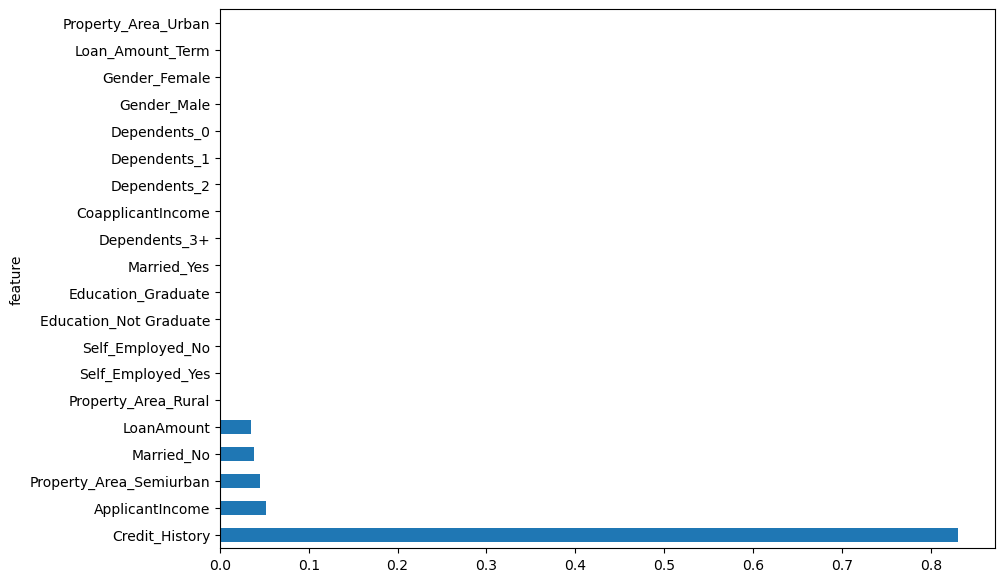

In [48]:
feature_imp(X_train, dt_grid).plot('feature','importance','barh',figsize=(10,7),legend=False)